In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle


import plotly.graph_objects as go
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, RepeatVector, Reshape, Flatten, TimeDistributed, Conv2D, MaxPool2D, Conv1DTranspose, LSTM, RepeatVector, Dropout


import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from target import TargetSet
from image import ImageSetObject, show_image
from model import VAE, loss_function, get_text_from_predict, score

In [2]:
def get_predictive_network(max_len, vocab_size):
    predictive_network = Sequential(
    [
        Conv2D(filters=32, kernel_size=5,
               strides=(1, 1), activation='relu'),
        MaxPool2D(),
        Conv2D(filters=64, kernel_size=5,
               strides=(1, 1), activation='relu'),
        MaxPool2D(),
        Flatten(),
        RepeatVector(max_len),
        LSTM(8, return_sequences=True),
        TimeDistributed(Dense(vocab_size))
    ])
    return predictive_network

# Load target file

In [3]:
TargetBMS = TargetSet()

# Load image data

In [4]:
# Folders
folders = '0123456789abcdef'

# Random seed
random_state=0

# Parameters
new_shape=[32, 32]

In [22]:
# Images data 
dataset = 'train'
i = folders[0]
j = folders[0]

list_data = []
list_id = []

for k in tqdm(folders):

    path = f'bms-molecular-translation/{dataset}/{i}/{j}/{k}/'

    # Files
    list_names = os.listdir(path)
    list_path = [path]*len(list_names)

    # Image data
    ImageSet = ImageSetObject(list_names, list_path)
    ImageSet.prepare_data(new_shape, filtering=False, adjust=False)
    data = ImageSet.X
    list_data.append(data)
    list_id.append([x.split('.')[0] for x in ImageSet.list_names])

# Select data
data = np.concatenate(list_data)
list_id = np.concatenate(list_id)

100%|█████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]



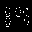

In [9]:
# Show
n = 8
fig = make_subplots(rows=1, cols=n)
for i in range(n):
    fig.add_trace(show_image(data[i, :, :, 0]).data[0], row = 1, col = i+1)
fig.update_layout(
    height=100,
    coloraxis_showscale=False, 
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Target preprocessing

In [23]:
# Target shapes
dico_targets_shape = {}

for name_target in ['target_A', 'target_B', 'target_C']:
    df_targets = TargetBMS.targets[name_target]

    # Text processing
    text = ''.join(df_targets.values)

    # Vocab
    vocab = [' '] + sorted(set(text))
    vocab_size = len(vocab)

    # Mapping
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)

    # Max length
    max_len = max([len(x) for x in df_targets])
    
    print(f"{name_target} > vocab_size={vocab_size} | max_len={max_len}")
    
    dico_targets_shape[name_target] = {'vocab_size':vocab_size, 'max_len':max_len, 'idx2char':idx2char, 'char2idx':char2idx}

target_A > vocab_size=23 | max_len=20
target_B > vocab_size=16 | max_len=267
target_C > vocab_size=20 | max_len=139


In [ ]:
# TRAININ #
for name_target in ['target_A', 'target_B', 'target_C']:
    
    # Target parameters
    df_targets = TargetBMS.targets[name_target]
    max_len = dico_targets_shape[name_target]['max_len']
    vocab_size = dico_targets_shape[name_target]['vocab_size']
    char2idx = dico_targets_shape[name_target]['char2idx']
    idx2char = dico_targets_shape[name_target]['idx2char']

    # Text targets
    targets = df_targets[list_id].values
    targets = [[char2idx[x] for x in target] for target in targets]
    targets = pad_sequences(targets, padding='post', maxlen=max_len)

    # Train predictive model
    predictive_network = get_predictive_network(max_len, vocab_size)

    # Data
    data = data

    # Train
    epochs=10
    batch_size=16
    patience=10
    lr=1e-3
    name=f'BMS_predictive_end_to_end_{name_target}'

    # Split train/test
    data, targets = shuffle(data, targets, random_state=0)

    TRAIN_BUF = int(data.shape[0]*0.8)
    data_train = data[:TRAIN_BUF]
    data_validation = data[TRAIN_BUF:]

    targets_train = targets[:TRAIN_BUF]
    targets_validation = targets[TRAIN_BUF:]

    print(f"train: {len(data_train)} / validation: {len(data_validation)}")

    # Callbacks and compil
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint(f'outputs/{name}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    optimizer = Adam(learning_rate=lr)
    predictive_network.build(input_shape=(None, new_shape[0], new_shape[1], 1))
    predictive_network.compile(optimizer=optimizer, loss=loss_function)
    predictive_network.summary()

    history = predictive_network.fit(
        data_train, 
        targets_train, 
        validation_data = (data_validation, targets_validation), 
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=1,
        callbacks=[es, mc]
    )

train: 7640 / validation: 1910
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 1600)          0         
_________________________________________________________________
lstm_1 (LSTM)          

In [ ]:
# # Train Score 
# y_true=[''.join([idx2char[y] for y in yy]) for yy in targets_train[0:batch_size]]
# y_predict=get_text_from_predict(predictive_network, data_train[0:batch_size], idx2char)
# print(f"\t> Train Score: {score(y_true, y_predict)}")
# [f"{x} -> {y}" for x,y in zip(y_true[0:8], y_predict[0:8])]

# # Validation score 
# y_true=[''.join([idx2char[y] for y in yy]) for yy in targets_validation[0:batch_size]]
# y_predict=get_text_from_predict(predictive_network, data_validation[0:batch_size], idx2char)
# print(f"\t> Validation Score: {score(y_true, y_predict)}")
# [f"{x} -> {y}" for x,y in zip(y_true[0:8], y_predict[0:8])]

# Predict

In [ ]:
# Images data 
dataset = 'test'
i = folders[0]
j = folders[0]
k = folders[0]

list_data = []

for k in tqdm(folders):

    path = f'bms-molecular-translation/{dataset}/{i}/{j}/{k}/'

    # Files
    list_names = os.listdir(path)
    list_path = [path]*len(list_names)

    # Image data
    ImageSet = ImageSetObject(list_names, list_path)
    ImageSet.prepare_data(new_shape, filtering=False, adjust=False)
    data = ImageSet.X
    list_data.append(data)

    # Select data
    data = list_data[0]

    output = ['InChI=1S']*len(data)
    for name_target in ['target_A', 'target_B', 'target_C']:

        name=f'BMS_predictive_end_to_end_{name_target}'

        max_len = dico_targets_shape[name_target]['max_len']
        vocab_size = dico_targets_shape[name_target]['vocab_size']
        idx2char = dico_targets_shape[name_target]['idx2char']

        predictive_network = get_predictive_network(max_len, vocab_size)
        predictive_network.build(input_shape=(None, new_shape[0], new_shape[1], 1))
        predictive_network.load_weights(f"outputs/{name}.h5")

        y = get_text_from_predict(predictive_network, data, idx2char)

        output = [o + f'/{y[i]}' if y[i] != max_len*' ' else o for i,o in enumerate(output)]
        output = [o.replace(' ', '') for o in output]

# Sample_submission
sample_submission = pd.read_csv("outputs/submission.csv")
sample_submission = sample_submission.set_index('image_id')

# Prepare df
list_id = ImageSet.image_ids
df_output = pd.DataFrame([list_id, output], index=['image_id', 'InChI']).transpose().set_index('image_id')
sample_submission.loc[df_output.index,'InChI'] = df_output['InChI']

# Export
sample_submission.reset_index().to_csv('outputs/submission.csv', index=False)